For this task, I will use the CIFAR-10 dataset, which consists of 10 classes of coloured images, including airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. The dataset contains 60,000 images - 50,000 images for the training set and 10,000 images for the testing set. Each image is a 32x32 pixel RGB image (3 channels: red, green, and blue), labeled according to its class. The pixel values range from 0 to 255, representing the intensity of each color channel.

I imported the dataset from tensorflow as this seemed to be the easiest method.

Below I will load the dataset and display some of its characteristics mentioned above:

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Training set shape: (50000, 32, 32, 3) images
Test set shape: (10000, 32, 32, 3) images
Image dimensions: 32x32 pixels


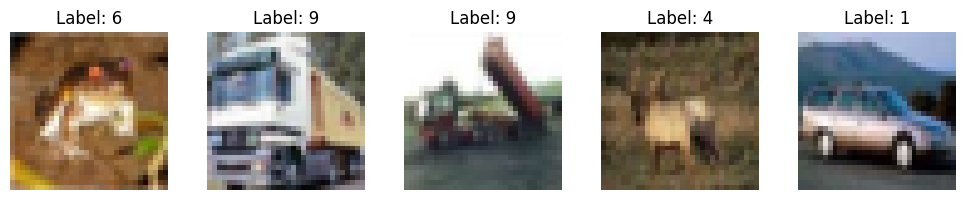

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Training set shape: {x_train.shape} images")
print(f"Test set shape: {x_test.shape} images")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]} pixels")

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i])
    ax.set_title(f"Label: {y_train[i][0]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

I will create a base convolutional neural network (using PyTorch) to classify images.
Firstly I need to normalise the images, I will use the "mean" and "std" values calulated to CIFAR-10 to normalize each RGB channel seperately:

In [2]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

test_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

Next I need to convert both the training and testing set to PyTorch tensors, as well as the labels, as this is what the model expects. I also apply the transformations above to x_train and y_train:

In [3]:
from PIL import Image

x_train_transformed = torch.stack([
    train_transform(Image.fromarray(img)) for img in x_train
])
x_test_transformed = torch.stack([
    test_transform(Image.fromarray(img)) for img in x_test
])

y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

Now the input is prepared, I will start building the model.
I will first need to establish a baseline CNN model, which I will build on and add improvements, and then carry out hyperparameter tuning:

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Base(nn.Module):
    def __init__(self):
        super(CNN_Base, self).__init__()

        # 1 Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)

        # 1 Fully Connected Layer
        self.fc1 = nn.Linear(16 * 30 * 30, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

base_model = CNN_Base()

# Baseline Hyperparameters

batch_size = 64
learning_rate = 0.001
num_epochs = 8

To start with, I have defined a simple base convolutional network with 1 convolutional layer and 1 fully connected layer.

In the forward pass function, the convolutional layer is applied with a ReLU activation function. The feature maps are then flattened into 1D to be fed into the fully connected layer. Then the fully connected layer is applied with no activation as it is handled in the loss function.

I have also specified the baseline hyperparameters:
- Batch size: 64 - (higher = more stable gradient updates but slower weight updates, lower = faster weight updates but gradients are noiser)
- Learning rate: 0.001 - (higher = faster training but risk of overshooting the minimum, lower = slower training but ensures more stable and precise convergence at minimum)
- Epochs: 8 - (higher = risk of overfitting, lower = risk of underfitting)

I also need to define the loss function and the optimizer for the baseline model. I will use cross-entropy loss as it is standard for multi-class classification problems, and also the adam optimizer:

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

Before training I will also need to wrap the data in loaders now that batch size is defined:

In [6]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train_transformed, y_train_tensor)
test_dataset = TensorDataset(x_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

I will use various metrics to measure the performance of the models:
- Loss - quantifies the model "error"
- Accuracy - proportion of correct predictions out of all
- Precision - measures the accuracy of positive predictions
- Recall - measures ability of the model to identify all positive cases
- F1 Score - combination of Precision and Recall, which is the harmonic mean of both

On the last epoch, I create a confusion matrix and format it with matplotlib and seaborn with a heatmap - like in tutorials.
Now I will train the model for the specified baseline number of epochs.

Epoch [1/8], Loss: 1.4785, Accuracy: 48.06%
Precision: 0.4770, Recall: 0.4806, F1 Score: 0.4784
Epoch [2/8], Loss: 1.1801, Accuracy: 59.12%
Precision: 0.5885, Recall: 0.5912, F1 Score: 0.5896
Epoch [3/8], Loss: 1.0506, Accuracy: 63.78%
Precision: 0.6357, Recall: 0.6378, F1 Score: 0.6365
Epoch [4/8], Loss: 0.9703, Accuracy: 66.59%
Precision: 0.6641, Recall: 0.6659, F1 Score: 0.6648
Epoch [5/8], Loss: 0.9039, Accuracy: 68.90%
Precision: 0.6876, Recall: 0.6890, F1 Score: 0.6881
Epoch [6/8], Loss: 0.8509, Accuracy: 70.90%
Precision: 0.7078, Recall: 0.7090, F1 Score: 0.7083
Epoch [7/8], Loss: 0.8022, Accuracy: 72.46%
Precision: 0.7234, Recall: 0.7246, F1 Score: 0.7239
Epoch [8/8], Loss: 0.7600, Accuracy: 73.85%
Precision: 0.7375, Recall: 0.7385, F1 Score: 0.7379


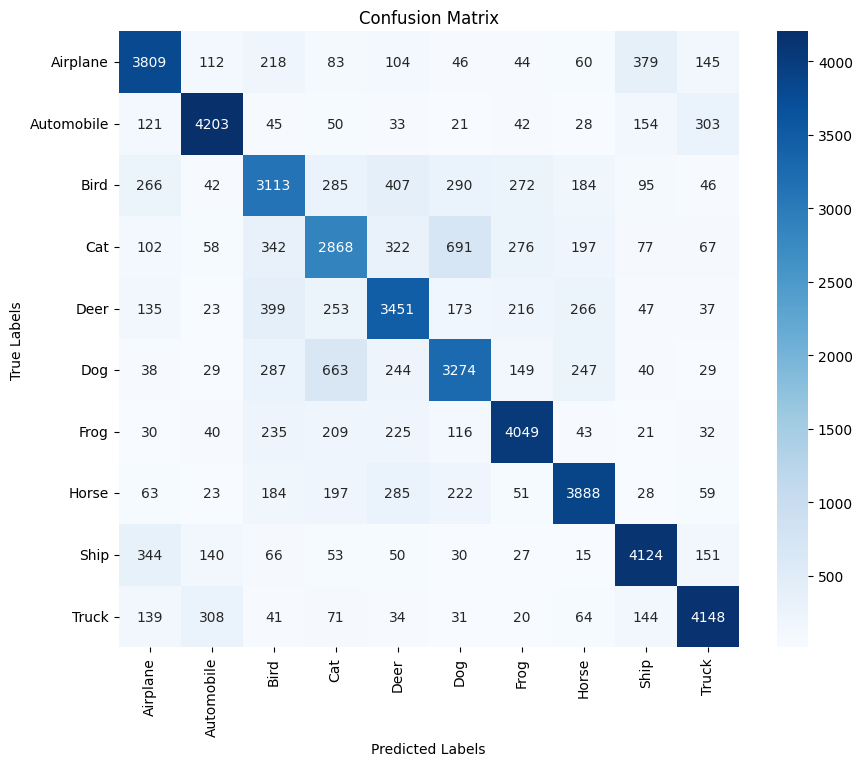

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
]

def train_model(model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_predictions = []

        for images, labels in train_loader:
            labels = labels.squeeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        if epoch == num_epochs - 1:
            cm = confusion_matrix(all_labels, all_predictions, labels=range(10))

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
            plt.xlabel("Predicted Labels")
            plt.ylabel("True Labels")
            plt.title("Confusion Matrix")
            plt.show()

train_model(base_model, base_optimizer)


As seen above, the model converges to 73.85% accuracy from the baseline model with a loss of 0.760. Precision and Recall are also low being 0.737 and 0.738, which leads to a low F1 score aswell.
The confusion matrix backs this up by showing true and false predictions for each class.

This creates a great starting point to build on.
I first want to experiment with adding 1 max pooling layer after the convolutional layer. This max pooling layer reduces the spatial dimensions of feature maps while retaining the most important information:

Epoch [1/8], Loss: 1.4322, Accuracy: 50.08%
Precision: 0.4957, Recall: 0.5008, F1 Score: 0.4973
Epoch [2/8], Loss: 1.1763, Accuracy: 59.07%
Precision: 0.5881, Recall: 0.5907, F1 Score: 0.5890
Epoch [3/8], Loss: 1.0863, Accuracy: 62.40%
Precision: 0.6213, Recall: 0.6240, F1 Score: 0.6223
Epoch [4/8], Loss: 1.0233, Accuracy: 64.64%
Precision: 0.6443, Recall: 0.6464, F1 Score: 0.6452
Epoch [5/8], Loss: 0.9857, Accuracy: 65.96%
Precision: 0.6576, Recall: 0.6596, F1 Score: 0.6584
Epoch [6/8], Loss: 0.9579, Accuracy: 67.02%
Precision: 0.6684, Recall: 0.6702, F1 Score: 0.6692
Epoch [7/8], Loss: 0.9324, Accuracy: 67.58%
Precision: 0.6741, Recall: 0.6758, F1 Score: 0.6748
Epoch [8/8], Loss: 0.9144, Accuracy: 68.46%
Precision: 0.6828, Recall: 0.6846, F1 Score: 0.6835


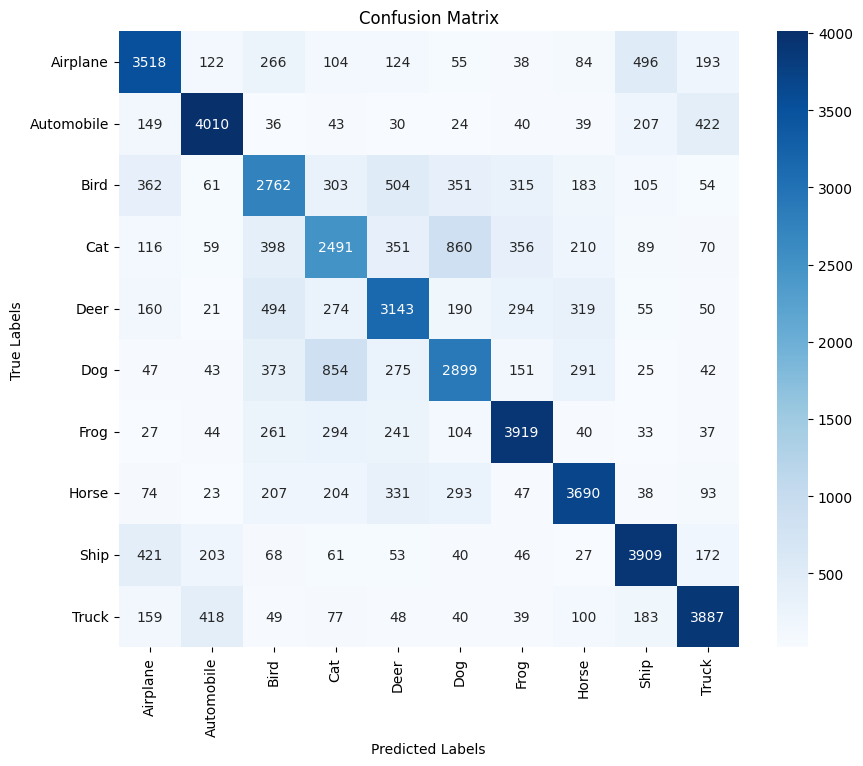

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Pool(nn.Module):
    def __init__(self):
        super(CNN_Pool, self).__init__()

        # 1 Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)

        # 1 Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 1 Fully Connected Layer
        self.fc1 = nn.Linear(16 * 15 * 15, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

pool_model = CNN_Pool()
pool_optimizer = optim.Adam(pool_model.parameters(), lr=learning_rate)

# Baseline Hyperparameters

batch_size = 64
learning_rate = 0.001
num_epochs = 8

train_model(pool_model, pool_optimizer)

The model with pooling shows a slight decrease in across metrics upon convergence, however it achieved its main goal of reducing memory usage and speeding up training time, as the model trained quicker.

Next, I would like to add 1 convolutional layer and 1 fully connected layer. The convolutional layer will allow the model to extract higher-level and more abstract features, whereas the extra fully connected layer will increase the model's ability to learn complex relationships between features:


Epoch [1/8], Loss: 1.2792, Accuracy: 54.29%
Precision: 0.5372, Recall: 0.5429, F1 Score: 0.5390
Epoch [2/8], Loss: 0.8972, Accuracy: 68.35%
Precision: 0.6806, Recall: 0.6835, F1 Score: 0.6818
Epoch [3/8], Loss: 0.7087, Accuracy: 75.11%
Precision: 0.7494, Recall: 0.7511, F1 Score: 0.7501
Epoch [4/8], Loss: 0.5243, Accuracy: 81.54%
Precision: 0.8146, Recall: 0.8154, F1 Score: 0.8150
Epoch [5/8], Loss: 0.3593, Accuracy: 87.64%
Precision: 0.8761, Recall: 0.8764, F1 Score: 0.8763
Epoch [6/8], Loss: 0.2199, Accuracy: 92.59%
Precision: 0.9258, Recall: 0.9259, F1 Score: 0.9259
Epoch [7/8], Loss: 0.1281, Accuracy: 95.73%
Precision: 0.9573, Recall: 0.9573, F1 Score: 0.9573
Epoch [8/8], Loss: 0.0948, Accuracy: 96.86%
Precision: 0.9686, Recall: 0.9686, F1 Score: 0.9686


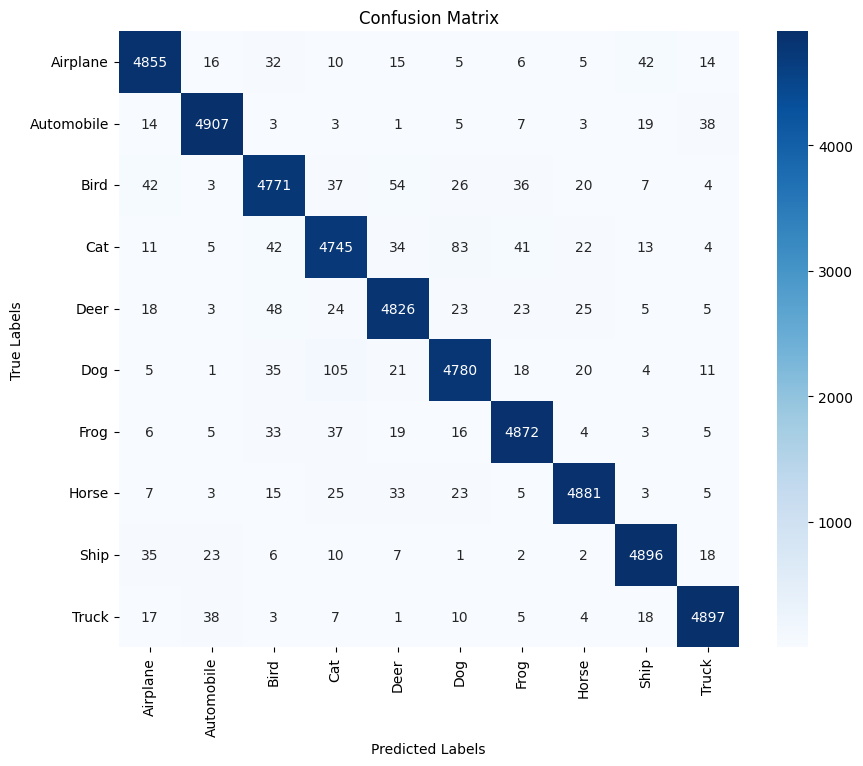

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Improved(nn.Module):
    def __init__(self):
        super(CNN_Improved, self).__init__()

        # 2 Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)

        # 1 Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2 Fully Connected Layers
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and optimizer
improved_model = CNN_Improved()
improved_optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 8

train_model(improved_model, improved_optimizer)

It is clear that the model improvements have allowed the model to converge at almost 97% accuracy, which is a significant improvement from the baseline model.

Now that I have added improvements to the model, I will undertake hyperparameter tuning for the improved model to determine the best settings to use.
Firstly I want to test the model with multiple learning rates, so I created an array with 4 different learning rate options, and trained the improved model for each one to see the effects:

Learning Rate: 0.1
------------------------------
Epoch [1/8], Loss: 15.8824, Accuracy: 10.13%
Precision: 0.1014, Recall: 0.1013, F1 Score: 0.1004
Epoch [2/8], Loss: 2.3116, Accuracy: 10.04%
Precision: 0.1002, Recall: 0.1004, F1 Score: 0.0982
Epoch [3/8], Loss: 2.3112, Accuracy: 9.97%
Precision: 0.0991, Recall: 0.0997, F1 Score: 0.0971
Epoch [4/8], Loss: 2.3118, Accuracy: 10.00%
Precision: 0.0996, Recall: 0.1000, F1 Score: 0.0975
Epoch [5/8], Loss: 2.3114, Accuracy: 10.00%
Precision: 0.0989, Recall: 0.1000, F1 Score: 0.0969
Epoch [6/8], Loss: 2.3110, Accuracy: 10.19%
Precision: 0.1012, Recall: 0.1019, F1 Score: 0.0993
Epoch [7/8], Loss: 2.3112, Accuracy: 9.99%
Precision: 0.0996, Recall: 0.0999, F1 Score: 0.0985
Epoch [8/8], Loss: 2.3123, Accuracy: 10.20%
Precision: 0.1023, Recall: 0.1020, F1 Score: 0.1003


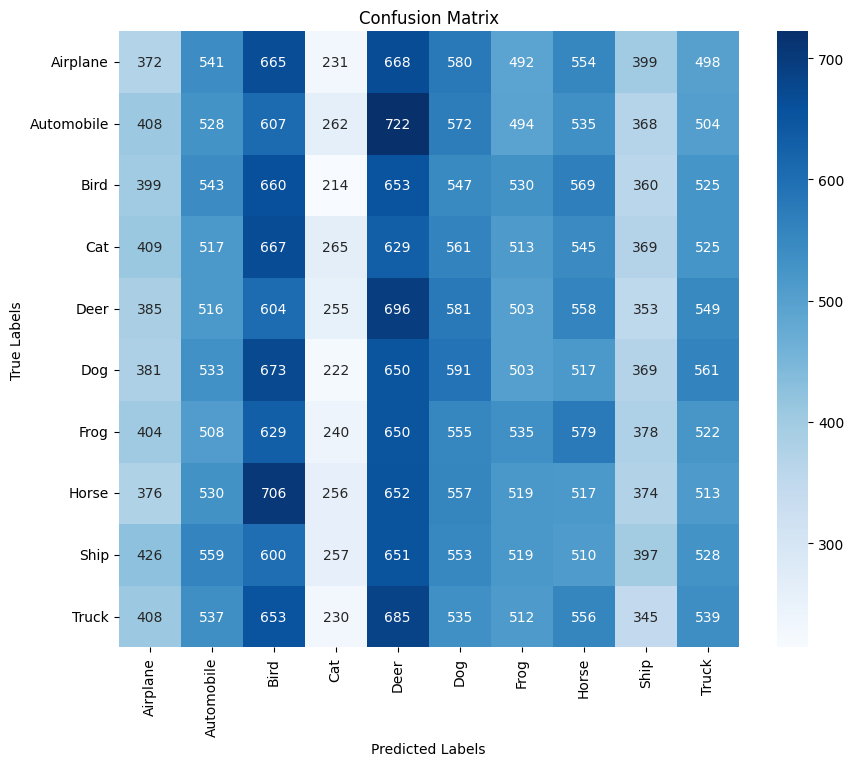

Learning Rate: 0.01
------------------------------
Epoch [1/8], Loss: 2.3134, Accuracy: 9.94%
Precision: 0.0993, Recall: 0.0994, F1 Score: 0.0962
Epoch [2/8], Loss: 2.3035, Accuracy: 10.00%
Precision: 0.0995, Recall: 0.1000, F1 Score: 0.0973
Epoch [3/8], Loss: 2.3037, Accuracy: 9.98%
Precision: 0.0985, Recall: 0.0998, F1 Score: 0.0940
Epoch [4/8], Loss: 2.3037, Accuracy: 9.89%
Precision: 0.0982, Recall: 0.0989, F1 Score: 0.0956
Epoch [5/8], Loss: 2.3034, Accuracy: 9.80%
Precision: 0.0967, Recall: 0.0980, F1 Score: 0.0943
Epoch [6/8], Loss: 2.3035, Accuracy: 10.24%
Precision: 0.0998, Recall: 0.1024, F1 Score: 0.0890
Epoch [7/8], Loss: 2.3035, Accuracy: 9.68%
Precision: 0.0941, Recall: 0.0968, F1 Score: 0.0891
Epoch [8/8], Loss: 2.3035, Accuracy: 10.08%
Precision: 0.0994, Recall: 0.1008, F1 Score: 0.0891


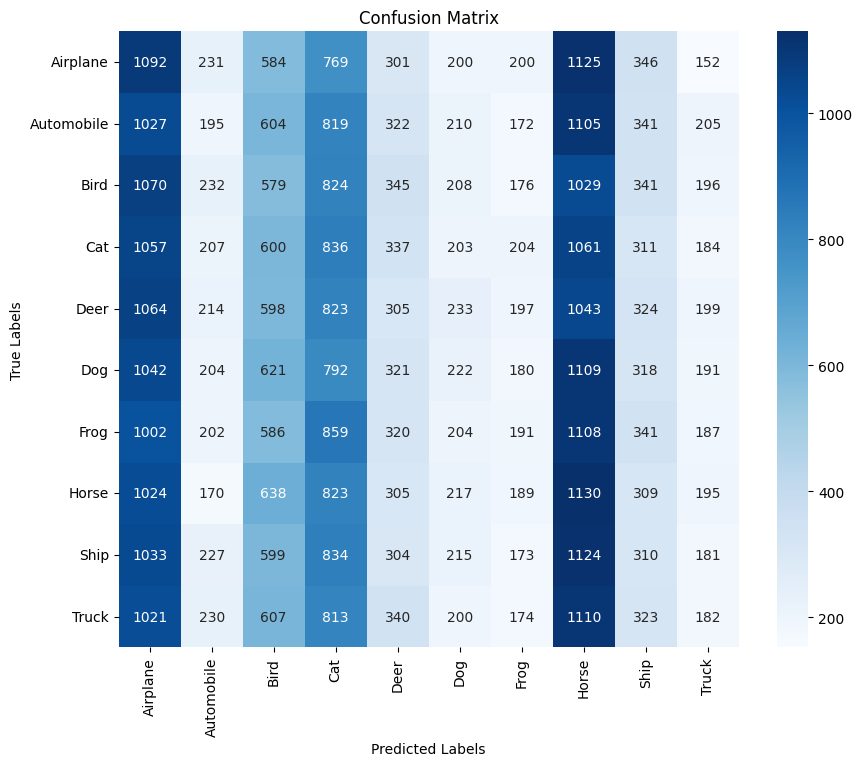

Learning Rate: 0.001
------------------------------
Epoch [1/8], Loss: 1.3167, Accuracy: 52.58%
Precision: 0.5197, Recall: 0.5258, F1 Score: 0.5211
Epoch [2/8], Loss: 0.9364, Accuracy: 67.36%
Precision: 0.6706, Recall: 0.6736, F1 Score: 0.6718
Epoch [3/8], Loss: 0.7641, Accuracy: 73.16%
Precision: 0.7298, Recall: 0.7316, F1 Score: 0.7305
Epoch [4/8], Loss: 0.6166, Accuracy: 78.19%
Precision: 0.7809, Recall: 0.7819, F1 Score: 0.7814
Epoch [5/8], Loss: 0.4693, Accuracy: 83.54%
Precision: 0.8350, Recall: 0.8354, F1 Score: 0.8351
Epoch [6/8], Loss: 0.3314, Accuracy: 88.54%
Precision: 0.8851, Recall: 0.8854, F1 Score: 0.8852
Epoch [7/8], Loss: 0.2250, Accuracy: 92.38%
Precision: 0.9236, Recall: 0.9238, F1 Score: 0.9237
Epoch [8/8], Loss: 0.1514, Accuracy: 94.86%
Precision: 0.9485, Recall: 0.9486, F1 Score: 0.9485


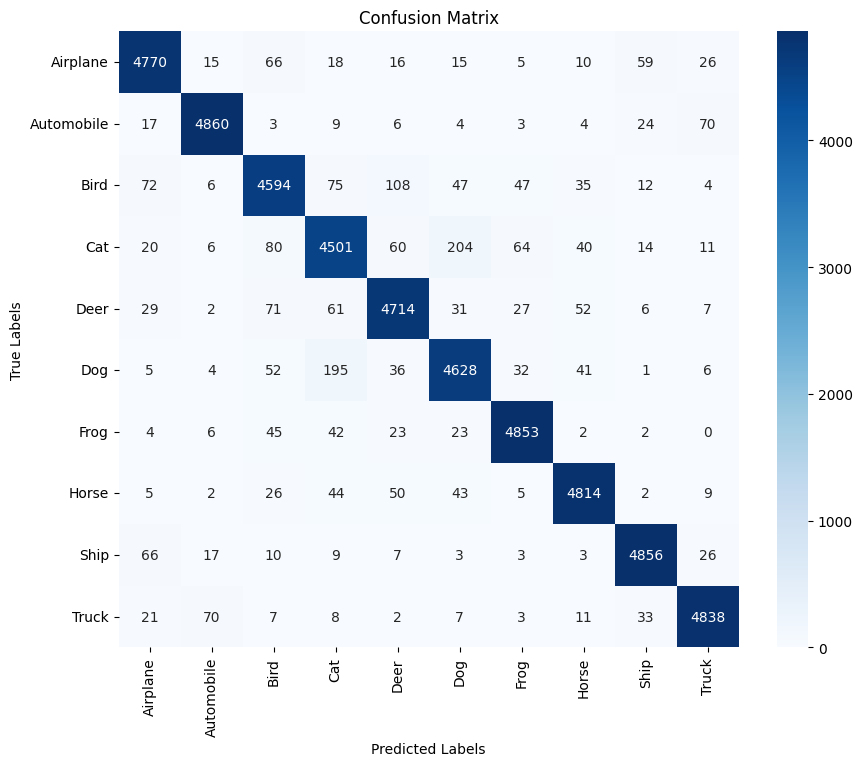

Learning Rate: 0.0001
------------------------------
Epoch [1/8], Loss: 1.6433, Accuracy: 42.07%
Precision: 0.4150, Recall: 0.4207, F1 Score: 0.4146
Epoch [2/8], Loss: 1.3241, Accuracy: 53.30%
Precision: 0.5292, Recall: 0.5330, F1 Score: 0.5301
Epoch [3/8], Loss: 1.1990, Accuracy: 57.73%
Precision: 0.5737, Recall: 0.5773, F1 Score: 0.5748
Epoch [4/8], Loss: 1.1095, Accuracy: 61.31%
Precision: 0.6095, Recall: 0.6131, F1 Score: 0.6108
Epoch [5/8], Loss: 1.0401, Accuracy: 63.82%
Precision: 0.6352, Recall: 0.6382, F1 Score: 0.6363
Epoch [6/8], Loss: 0.9817, Accuracy: 65.76%
Precision: 0.6548, Recall: 0.6576, F1 Score: 0.6559
Epoch [7/8], Loss: 0.9279, Accuracy: 68.03%
Precision: 0.6777, Recall: 0.6803, F1 Score: 0.6787
Epoch [8/8], Loss: 0.8792, Accuracy: 69.57%
Precision: 0.6934, Recall: 0.6957, F1 Score: 0.6943


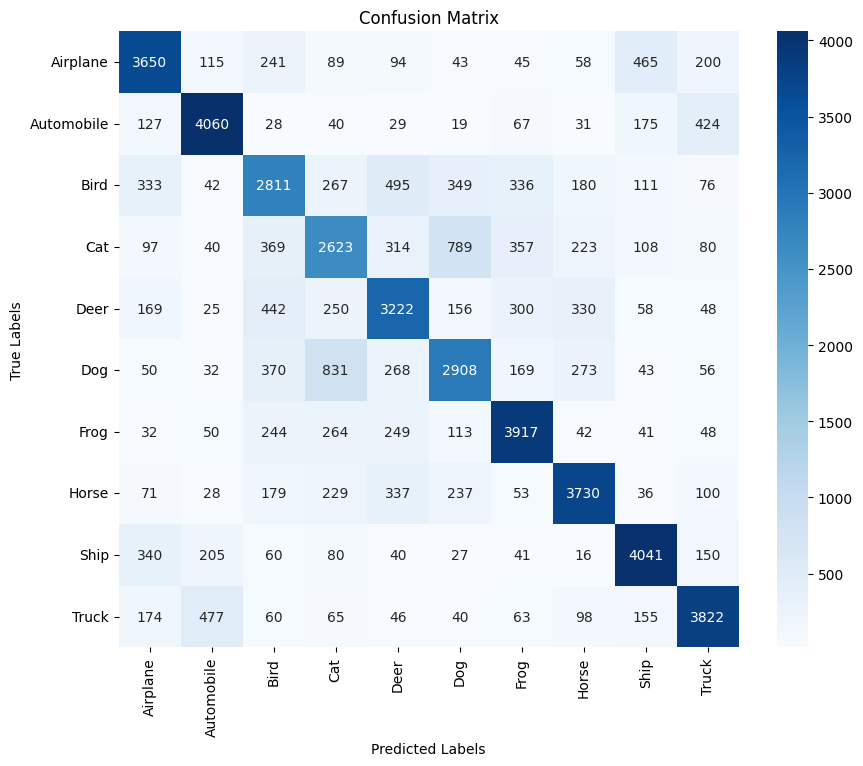

In [10]:
rates = [0.1, 0.01, 0.001, 0.0001]

for rate in rates:
    imp_model = CNN_Improved()
    imp_optimizer = torch.optim.Adam(imp_model.parameters(), lr=rate)
    print(f"Learning Rate: {rate}")
    print("-"*30)
    train_model(imp_model, imp_optimizer)

From the hyperparameter testing above, it is clear that 0.1 and 0.01 learning rates are too low for this model, preventing it from reaching the global minima.
0.001 seems perfect as the model converges at 97% accuracy and the learning process is stable, however 0.0001 is too slow and the model doesn't converge fast enough.

Next I want to experiment with a 3 different optimizers and see their effects on the model:

Testing Optimizer: SGD
------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/8], Loss: 2.2646, Accuracy: 19.82%
Precision: 0.2083, Recall: 0.1982, F1 Score: 0.1571
Epoch [2/8], Loss: 2.1210, Accuracy: 26.79%
Precision: 0.2978, Recall: 0.2679, F1 Score: 0.2336
Epoch [3/8], Loss: 1.9829, Accuracy: 30.83%
Precision: 0.3123, Recall: 0.3083, F1 Score: 0.2854
Epoch [4/8], Loss: 1.8856, Accuracy: 34.22%
Precision: 0.3374, Recall: 0.3422, F1 Score: 0.3267
Epoch [5/8], Loss: 1.8074, Accuracy: 36.86%
Precision: 0.3613, Recall: 0.3686, F1 Score: 0.3574
Epoch [6/8], Loss: 1.7449, Accuracy: 38.99%
Precision: 0.3822, Recall: 0.3899, F1 Score: 0.3811
Epoch [7/8], Loss: 1.6904, Accuracy: 40.85%
Precision: 0.4017, Recall: 0.4085, F1 Score: 0.4013
Epoch [8/8], Loss: 1.6425, Accuracy: 42.32%
Precision: 0.4169, Recall: 0.4232, F1 Score: 0.4170


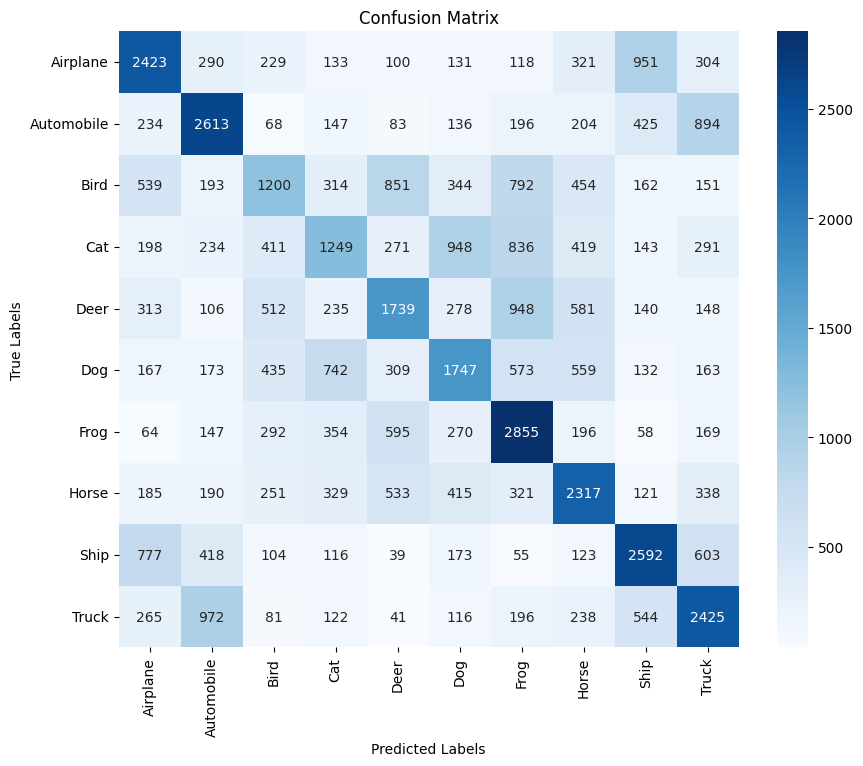

Testing Optimizer: SGD with Momentum
------------------------------
Epoch [1/8], Loss: 1.9129, Accuracy: 32.15%
Precision: 0.3173, Recall: 0.3215, F1 Score: 0.3057
Epoch [2/8], Loss: 1.5405, Accuracy: 45.41%
Precision: 0.4485, Recall: 0.4541, F1 Score: 0.4489
Epoch [3/8], Loss: 1.3346, Accuracy: 52.47%
Precision: 0.5201, Recall: 0.5247, F1 Score: 0.5214
Epoch [4/8], Loss: 1.2089, Accuracy: 57.23%
Precision: 0.5683, Recall: 0.5723, F1 Score: 0.5697
Epoch [5/8], Loss: 1.1154, Accuracy: 60.72%
Precision: 0.6039, Recall: 0.6072, F1 Score: 0.6051
Epoch [6/8], Loss: 1.0307, Accuracy: 63.83%
Precision: 0.6353, Recall: 0.6383, F1 Score: 0.6364
Epoch [7/8], Loss: 0.9514, Accuracy: 66.70%
Precision: 0.6644, Recall: 0.6670, F1 Score: 0.6654
Epoch [8/8], Loss: 0.8717, Accuracy: 69.37%
Precision: 0.6915, Recall: 0.6937, F1 Score: 0.6923


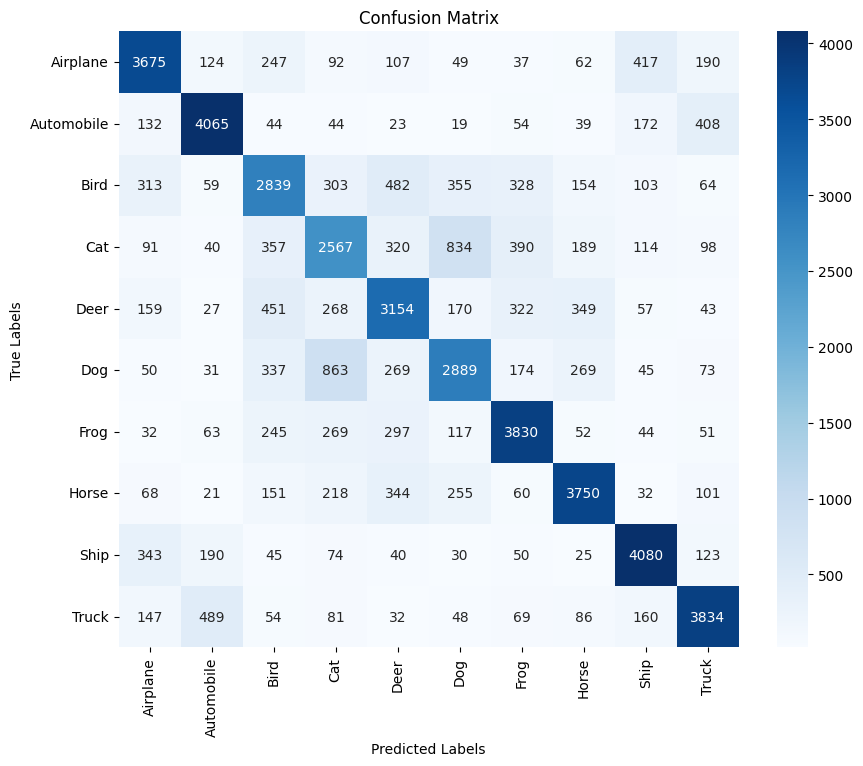

Testing Optimizer: Adam
------------------------------
Epoch [1/8], Loss: 1.3133, Accuracy: 52.73%
Precision: 0.5224, Recall: 0.5273, F1 Score: 0.5239
Epoch [2/8], Loss: 0.9199, Accuracy: 67.63%
Precision: 0.6737, Recall: 0.6763, F1 Score: 0.6748
Epoch [3/8], Loss: 0.7173, Accuracy: 74.76%
Precision: 0.7460, Recall: 0.7476, F1 Score: 0.7467
Epoch [4/8], Loss: 0.5376, Accuracy: 81.24%
Precision: 0.8115, Recall: 0.8124, F1 Score: 0.8119
Epoch [5/8], Loss: 0.3698, Accuracy: 87.18%
Precision: 0.8714, Recall: 0.8718, F1 Score: 0.8716
Epoch [6/8], Loss: 0.2222, Accuracy: 92.42%
Precision: 0.9241, Recall: 0.9242, F1 Score: 0.9241
Epoch [7/8], Loss: 0.1354, Accuracy: 95.52%
Precision: 0.9552, Recall: 0.9552, F1 Score: 0.9552
Epoch [8/8], Loss: 0.0923, Accuracy: 97.00%
Precision: 0.9700, Recall: 0.9700, F1 Score: 0.9700


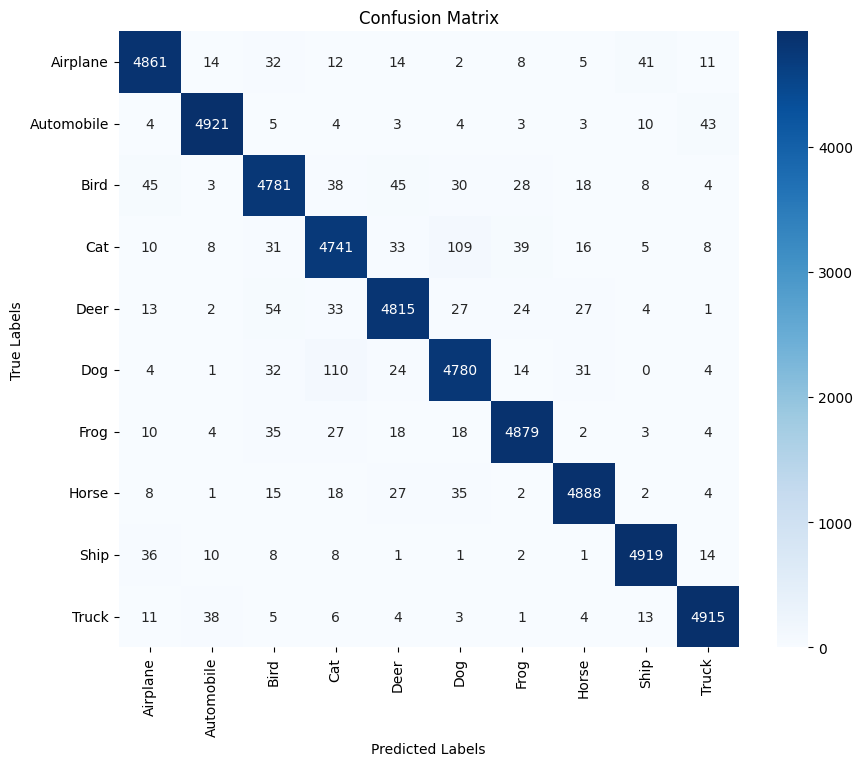

Testing Optimizer: RMSprop
------------------------------
Epoch [1/8], Loss: 1.3670, Accuracy: 51.72%
Precision: 0.5113, Recall: 0.5172, F1 Score: 0.5131
Epoch [2/8], Loss: 0.9606, Accuracy: 66.24%
Precision: 0.6588, Recall: 0.6624, F1 Score: 0.6602
Epoch [3/8], Loss: 0.7749, Accuracy: 72.90%
Precision: 0.7270, Recall: 0.7290, F1 Score: 0.7278
Epoch [4/8], Loss: 0.6092, Accuracy: 78.82%
Precision: 0.7871, Recall: 0.7882, F1 Score: 0.7876
Epoch [5/8], Loss: 0.4468, Accuracy: 84.60%
Precision: 0.8456, Recall: 0.8460, F1 Score: 0.8458
Epoch [6/8], Loss: 0.3016, Accuracy: 89.80%
Precision: 0.8978, Recall: 0.8980, F1 Score: 0.8979
Epoch [7/8], Loss: 0.1932, Accuracy: 93.47%
Precision: 0.9347, Recall: 0.9347, F1 Score: 0.9347
Epoch [8/8], Loss: 0.1242, Accuracy: 95.91%
Precision: 0.9591, Recall: 0.9591, F1 Score: 0.9591


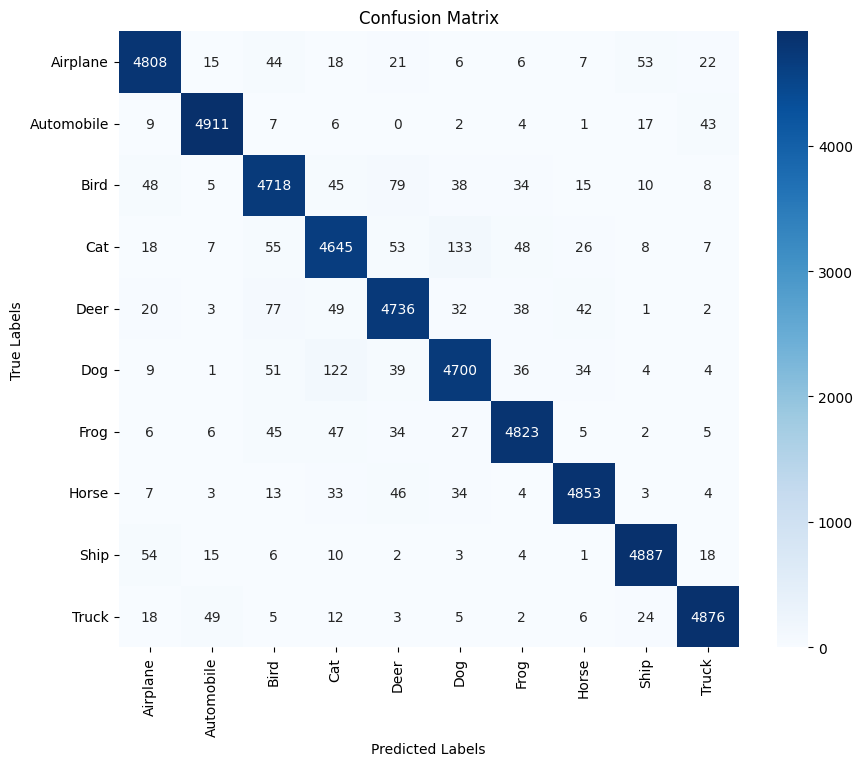

In [11]:
optimizers = [
    ("SGD", lambda params: torch.optim.SGD(params, lr=0.001)),
    ("SGD with Momentum", lambda params: torch.optim.SGD(params, lr=0.001, momentum=0.9)),
    ("Adam", lambda params: torch.optim.Adam(params, lr=0.001)),
    ("RMSprop", lambda params: torch.optim.RMSprop(params, lr=0.001))
]

for optimizer_name, optimizer_func in optimizers:
    imp_model = CNN_Improved()
    imp_optimizer = optimizer_func(imp_model.parameters())

    print(f"Testing Optimizer: {optimizer_name}")
    print("-" * 30)

    train_model(imp_model, imp_optimizer)

From the results above, the RMSprop optimizer yielded slightly higher results across all metrics, so I will use this going forward.

Next I would like to test adding 2 more epochs to allow the model to fully converge at the minima:

Epoch [1/10], Loss: 1.3953, Accuracy: 50.74%
Precision: 0.5036, Recall: 0.5074, F1 Score: 0.5035
Epoch [2/10], Loss: 0.9440, Accuracy: 67.15%
Precision: 0.6686, Recall: 0.6715, F1 Score: 0.6698
Epoch [3/10], Loss: 0.7402, Accuracy: 74.11%
Precision: 0.7393, Recall: 0.7411, F1 Score: 0.7400
Epoch [4/10], Loss: 0.5588, Accuracy: 80.64%
Precision: 0.8055, Recall: 0.8064, F1 Score: 0.8059
Epoch [5/10], Loss: 0.3839, Accuracy: 86.92%
Precision: 0.8688, Recall: 0.8692, F1 Score: 0.8690
Epoch [6/10], Loss: 0.2386, Accuracy: 91.98%
Precision: 0.9197, Recall: 0.9198, F1 Score: 0.9197
Epoch [7/10], Loss: 0.1411, Accuracy: 95.26%
Precision: 0.9526, Recall: 0.9526, F1 Score: 0.9526
Epoch [8/10], Loss: 0.0909, Accuracy: 96.98%
Precision: 0.9698, Recall: 0.9698, F1 Score: 0.9698
Epoch [9/10], Loss: 0.0665, Accuracy: 97.90%
Precision: 0.9790, Recall: 0.9790, F1 Score: 0.9790
Epoch [10/10], Loss: 0.0597, Accuracy: 98.06%
Precision: 0.9806, Recall: 0.9806, F1 Score: 0.9806


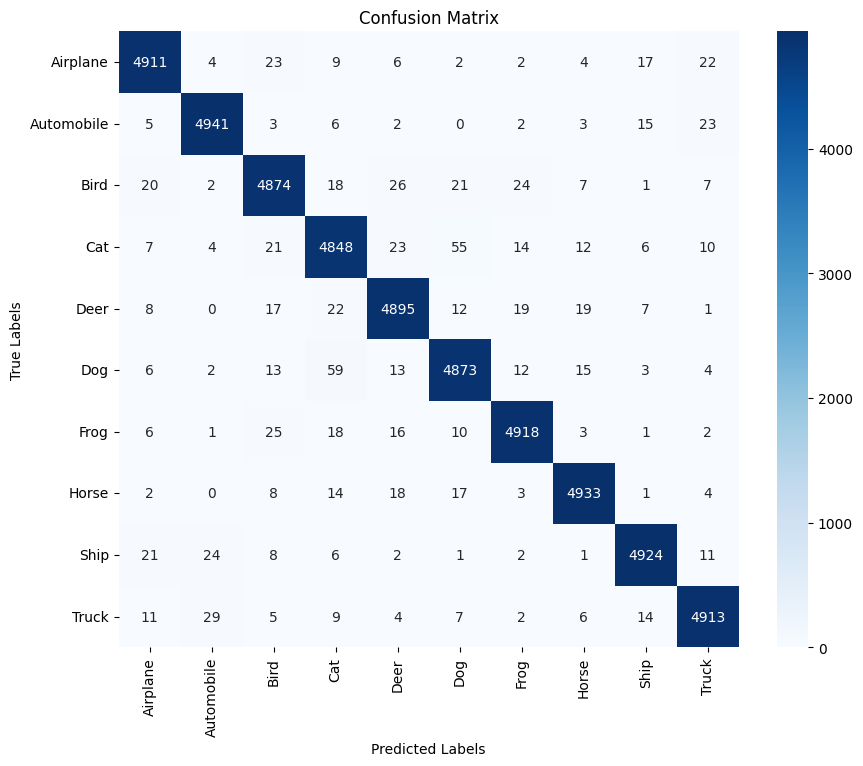

In [12]:
improved_model = CNN_Improved()
improved_optimizer = torch.optim.RMSprop(improved_model.parameters(), lr=0.001)

def train_model_epoch(model, optimizer, epochs):
    for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            all_labels = []
            all_predictions = []

            for images, labels in train_loader:
                labels = labels.squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            precision = precision_score(all_labels, all_predictions, average='weighted')
            recall = recall_score(all_labels, all_predictions, average='weighted')
            f1 = f1_score(all_labels, all_predictions, average='weighted')

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

            if epoch == 9:
                cm = confusion_matrix(all_labels, all_predictions, labels=range(10))

                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
                plt.xlabel("Predicted Labels")
                plt.ylabel("True Labels")
                plt.title("Confusion Matrix")
                plt.show()

train_model_epoch(improved_model, improved_optimizer, 10)

Adding 2 more epochs allows slightly more convergence and doesn't contribute heavily to overfitting, so I will use this going forward.

Finally, I will test my final model on the holdout testing set to see how well it generalises to completely fresh data:

Test Loss: 2.2871, Accuracy: 66.49%
Precision: 0.6812, Recall: 0.6649, F1 Score: 0.6672


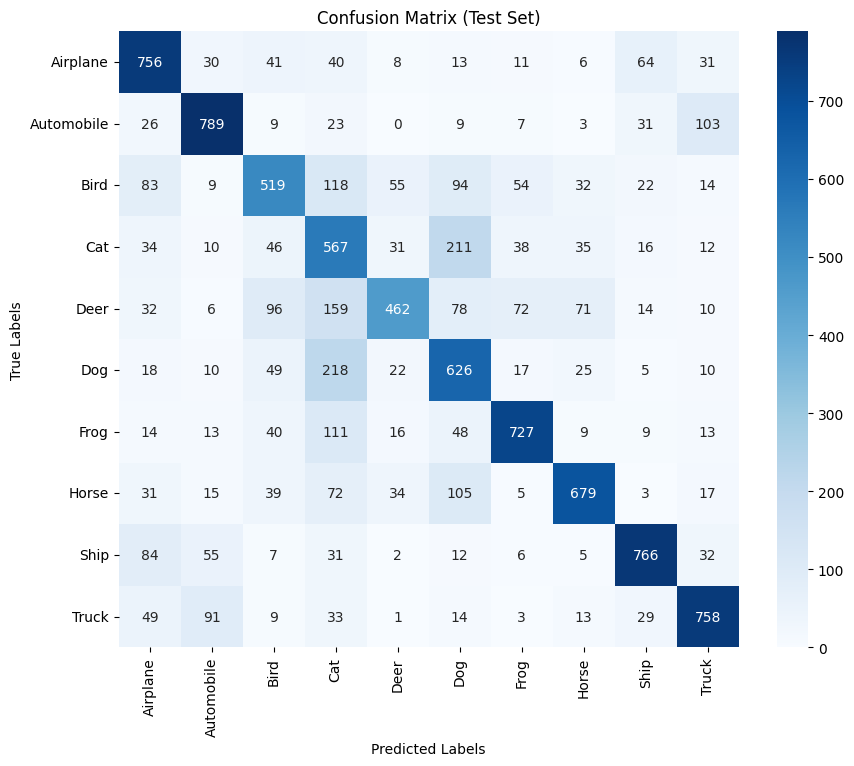

In [13]:
improved_model.eval()
running_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.squeeze(1)
        outputs = improved_model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {running_loss/len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

cm = confusion_matrix(all_labels, all_predictions, labels=range(10))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Set)")
plt.show()

Unfortunately, as seen above the model doesn't generalise too well to new and unseen data giving an accuracy of only 66%. I will need to expand the architecture even further from the improved model to allow the CNN to capture more complex features of images.
My machine is not powerful enough to run such models, so I will switch to a Google Colab environment with another file where I can experiment on expanded models that will run on an advanced GPU instead of a CPU.